In [20]:
import os
import pandas as pd
import numpy as np

def load_task_data(task_name, relevant_columns, root_dir="../../../data"):
    """
    Loads all subject CSVs corresponding to a specified task, extracts relevant columns, 
    and appends them (with the subject ID as the first column) into one DataFrame.
    
    Parameters:
        task_name (str): The name of the task folder (e.g., "AF", "NTS", "DWL").
        relevant_columns (list): A list of column names (strings) to extract from each CSV.
        root_dir (str): The root data directory. Default is "Data".
        
    Returns:
        pandas.DataFrame: A DataFrame containing the subject ID (as 'subjectID') and the relevant columns 
                          from every CSV that was found.
    """
    # List to collect dataframes for each subject
    data_frames = []
    
    # Loop through each study directory in the root directory
    for study in os.listdir(root_dir):
        study_path = os.path.join(root_dir, study)
        if os.path.isdir(study_path):
            # Loop through each site directory within the study directory
            for site in os.listdir(study_path):
                site_path = os.path.join(study_path, site)
                if os.path.isdir(site_path):
                    # Loop through each subject directory within the site directory
                    for subject in os.listdir(site_path):
                        subject_path = os.path.join(site_path, subject)
                        if os.path.isdir(subject_path):
                            # Construct the path to the task directory for this subject
                            task_path = os.path.join(subject_path, task_name)
                            if os.path.isdir(task_path):
                                # Look for the 'data' folder within the task directory
                                data_folder = os.path.join(task_path, "data")
                                if os.path.isdir(data_folder):
                                    # Process each CSV file found in the data folder
                                    for file in os.listdir(data_folder):
                                        if file.endswith(".csv"):
                                            csv_path = os.path.join(data_folder, file)
                                            try:
                                                # Load the CSV into a temporary DataFrame
                                                temp_df = pd.read_csv(csv_path)
                                                # Select only the relevant columns (if they exist)
                                                # It is assumed that every CSV contains all desired columns; 
                                                # you may wish to add error handling if some files do not.
                                                filtered_df = temp_df[relevant_columns].copy()
                                                # Insert the subject ID as the first column
                                                filtered_df.insert(0, "subjectID", subject)
                                                # Append the DataFrame for this subject to the list
                                                data_frames.append(filtered_df)
                                            except Exception as e:
                                                print(f"Error processing {csv_path}: {e}")
                                            finally:
                                                # Delete the temporary dataframe to free memory
                                                del temp_df
                                                del filtered_df
                                        
    # Concatenate all subject DataFrames into one, resetting the index
    if data_frames:
        final_df = pd.concat(data_frames, ignore_index=True)
    else:
        # If no data was found, return an empty DataFrame with the appropriate columns
        final_df = pd.DataFrame(columns=["subjectID"] + relevant_columns)
    
    return final_df


In [21]:
# Specify the task and the relevant columns you want to extract from each CSV
task = "AF"  # for example, could be "NTS", "DWL", etc.
columns_to_extract = ["subject_id", "response_time", "correct", "condition"]

# Call the function to load and consolidate the data
af_df = load_task_data(task, columns_to_extract)

# You can now work with the combined_df DataFrame as needed.
print(af_df.head())

  subjectID  subject_id  response_time  correct condition
0      7049        7049            609        1       inc
1      7049        7049            540        1       con
2      7049        7049            640        1       inc
3      7049        7049            523        1       con
4      7049        7049            594        1       con


In [22]:
def add_study_and_site_columns(df):
    """
    Adds 'study' and 'site' columns based on the prefix of 'subjectID'.
    
    Rules:
    - If subjectID starts with 7 → study = 'obs'
    - Else → study = 'int'
    
    - If subjectID starts with 7 or 8 → site = 'UI'
    - Else → site = 'NE'
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing a 'subjectID' column.
    
    Returns:
        pd.DataFrame: The modified DataFrame with 'study' and 'site' columns.
    """

    df['study'] = df['subjectID'].astype(str).str.startswith('7').map({True: 'obs', False: 'int'})
    df['site'] = df['subjectID'].astype(str).str[0].map(lambda x: 'UI' if x in ['7', '8'] else 'NE')

    return df

af_df = add_study_and_site_columns(af_df)
print(af_df.head())

  subjectID  subject_id  response_time  correct condition study site
0      7049        7049            609        1       inc   obs   UI
1      7049        7049            540        1       con   obs   UI
2      7049        7049            640        1       inc   obs   UI
3      7049        7049            523        1       con   obs   UI
4      7049        7049            594        1       con   obs   UI


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.set_palette("deep")
sns.set_context("notebook")
import warnings 
warnings.filterwarnings("ignore")



# todo
- [ ] AF/NF percent correct per person by condition
- [ ] ATS/NTS percent correct per person by condition
- [ ] NNB/VNB proportion accuracy
- [ ] filter baseline only 
- [ ] DSST number completed, number correct, RT not priority
- [ ] WL count correc by each trial
- [ ] WL remove proportion and do count correct


Number of Correct Responses for inc condition: 5954
Number of Incorrect Responses for inc condition: 366
Number of Correct Responses for con condition: 5889
Number of Incorrect Responses for con condition: 431


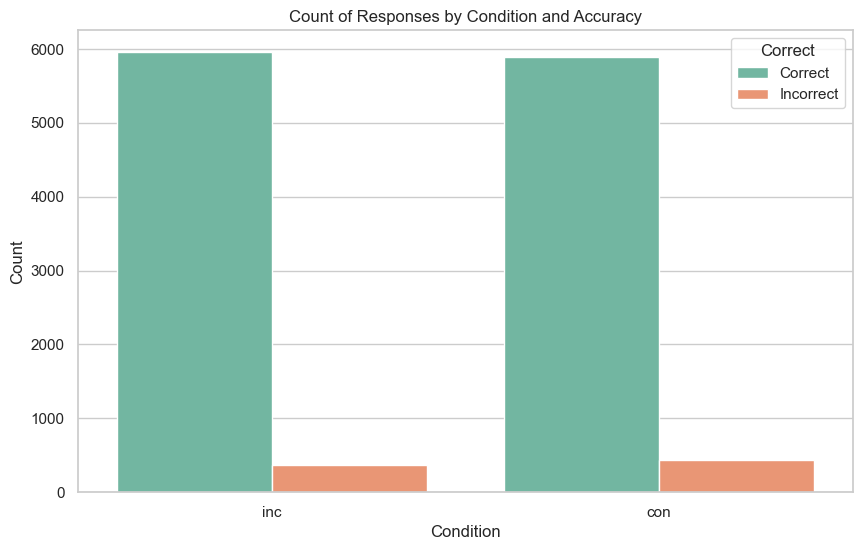

In [24]:
# plot group level count plot for accuracy (correct by condition)
plt.figure(figsize=(10, 6))
# print values of correct and incorrect by condition
print(f"Number of Correct Responses for inc condition: {af_df[af_df['condition'] == 'inc']['correct'].value_counts().get(1, 0)}")
print(f"Number of Incorrect Responses for inc condition: {af_df[af_df['condition'] == 'inc']['correct'].value_counts().get(0, 0)}")
print(f"Number of Correct Responses for con condition: {af_df[af_df['condition'] == 'con']['correct'].value_counts().get(1, 0)}")
print(f"Number of Incorrect Responses for con condition: {af_df[af_df['condition'] == 'con']['correct'].value_counts().get(0, 0)}")
# set 0 for incorrect and 1 for correct
af_df['correct'] = af_df['correct'].map({0: 'Incorrect', 1: 'Correct'})
sns.countplot(data=af_df, x='condition', hue='correct', palette='Set2')
plt.title('Count of Responses by Condition and Accuracy')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.legend(title='Correct', loc='upper right')
plt.show()

Text(0.5, 1.0, 'Response Time by Condition (Group Level)')

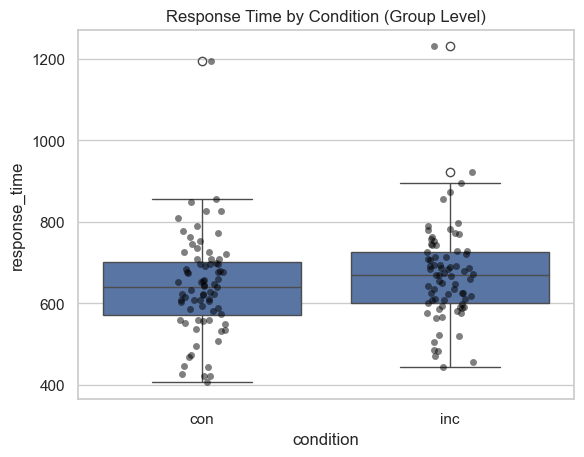

In [25]:
grouped_rt = af_df.groupby(['condition', 'subjectID'])['response_time'].mean().reset_index()

sns.boxplot(data=grouped_rt, x='condition', y='response_time')
sns.stripplot(data=grouped_rt, x='condition', y='response_time', color='black', alpha=0.5, jitter=True)
plt.title("Response Time by Condition (Group Level)")

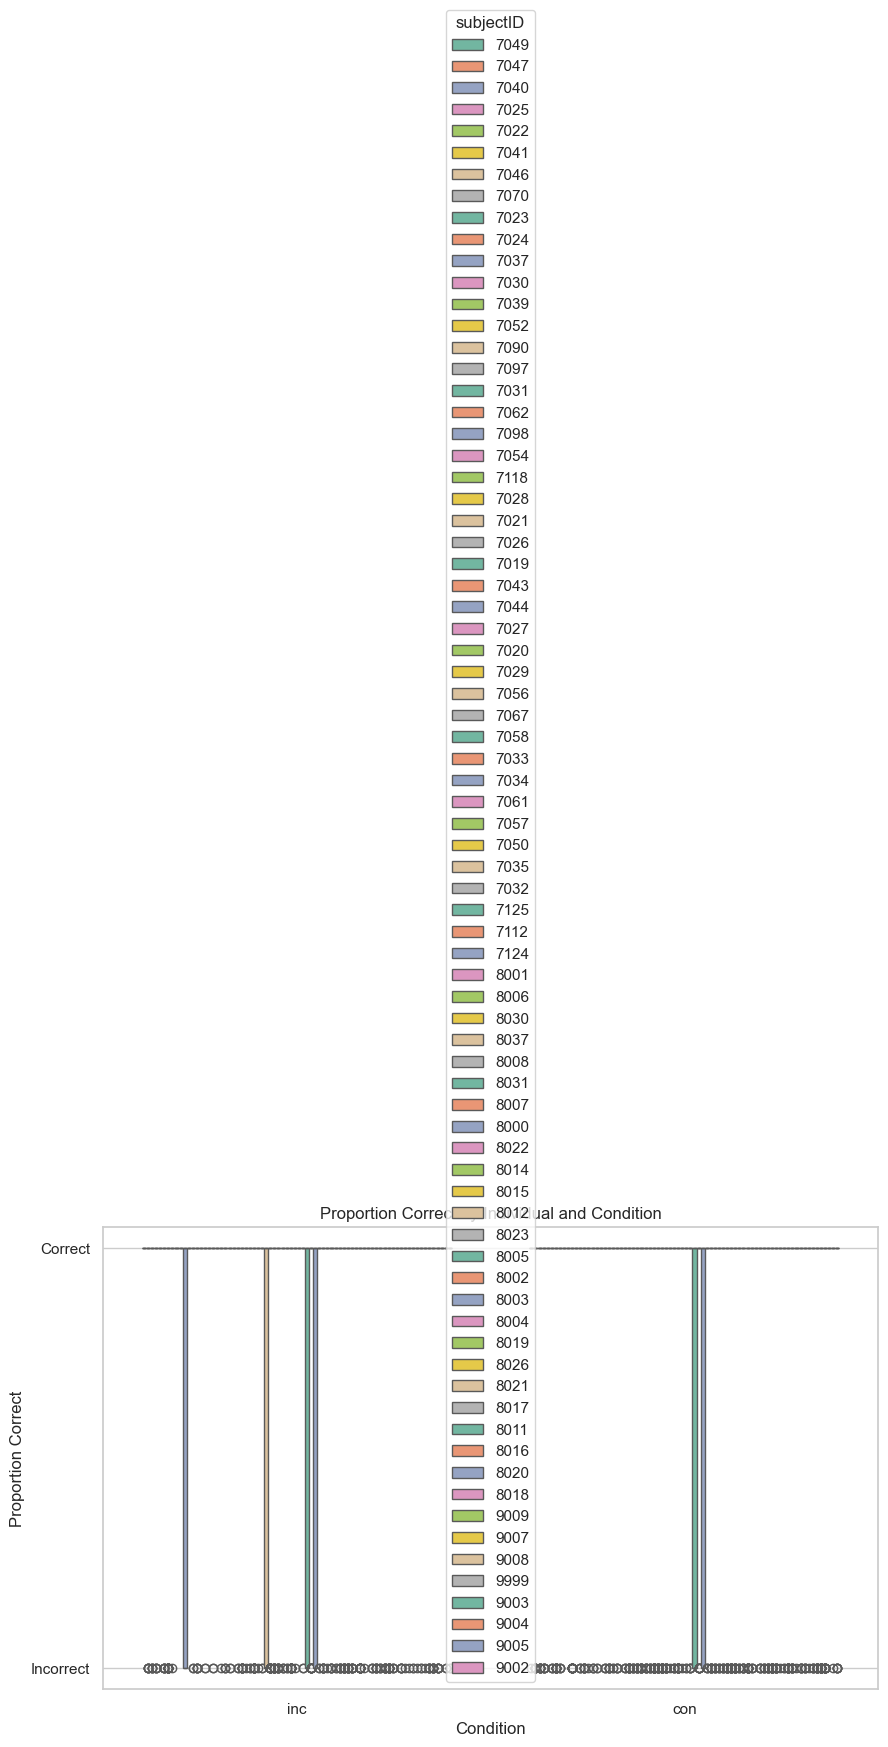

In [46]:
# box with swarm proportion correct by individual by condition no response time
plt.figure(figsize=(10, 6))
sns.boxplot(data=af_df, x='condition', y='correct', hue='subjectID', palette='Set2')
plt.title("Proportion Correct by Individual and Condition")
plt.xlabel('Condition')
plt.ylabel('Proportion Correct')
plt.show()


Number of Correct Responses for inc condition: 5983
Number of Incorrect Responses for inc condition: 321
Number of Correct Responses for con condition: 6007
Number of Incorrect Responses for con condition: 297


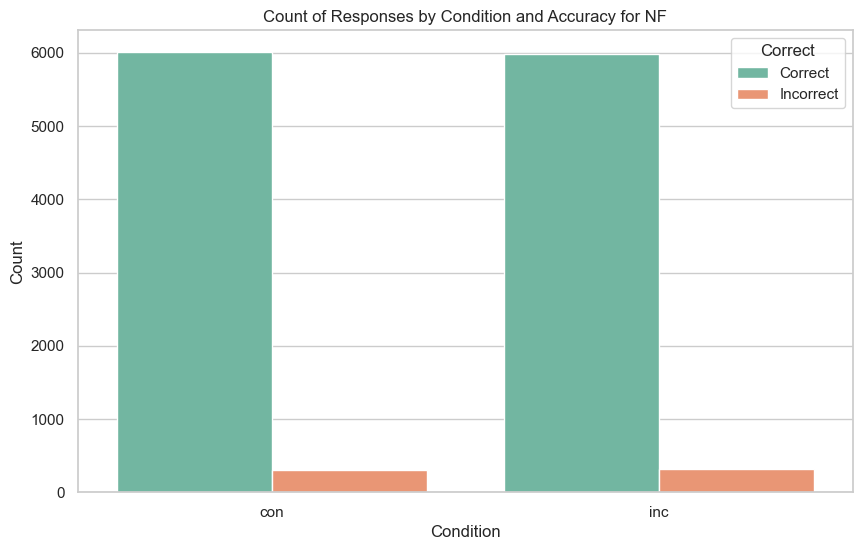

In [26]:
nf_df = load_task_data("NF", columns_to_extract)
nf_df = add_study_and_site_columns(nf_df)
# plot group level count plot for accuracy (correct by condition) for NF
plt.figure(figsize=(10, 6))
# print values of correct and incorrect by condition for NF
print(f"Number of Correct Responses for inc condition: {nf_df[nf_df['condition'] == 'inc']['correct'].value_counts().get(1, 0)}")
print(f"Number of Incorrect Responses for inc condition: {nf_df[nf_df['condition'] == 'inc']['correct'].value_counts().get(0, 0)}")
print(f"Number of Correct Responses for con condition: {nf_df[nf_df['condition'] == 'con']['correct'].value_counts().get(1, 0)}")
print(f"Number of Incorrect Responses for con condition: {nf_df[nf_df['condition'] == 'con']['correct'].value_counts().get(0, 0)}")
# set 0 for incorrect and 1 for correct
nf_df['correct'] = nf_df['correct'].map({0: 'Incorrect', 1: 'Correct'})
sns.countplot(data=nf_df, x='condition', hue='correct', palette='Set2')
plt.title('Count of Responses by Condition and Accuracy for NF')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.legend(title='Correct', loc='upper right')
plt.show()



Text(0.5, 1.0, 'Response Time by Condition (Group Level)')

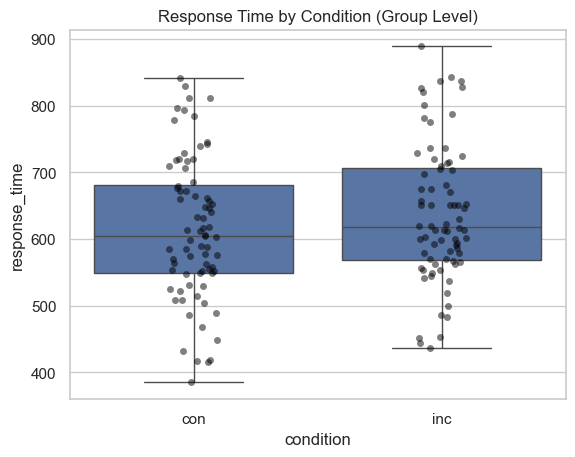

In [27]:
grouped_rt = nf_df.groupby(['condition', 'subjectID'])['response_time'].mean().reset_index()

sns.boxplot(data=grouped_rt, x='condition', y='response_time')
sns.stripplot(data=grouped_rt, x='condition', y='response_time', color='black', alpha=0.5, jitter=True)
plt.title("Response Time by Condition (Group Level)")


In [28]:
columns_to_extract = ['block', 'block_cond', 'correct', 'response_time']
ats_df = load_task_data("ATS", columns_to_extract)
ats_df = add_study_and_site_columns(ats_df)
ats_df = ats_df[ats_df['block']=='test']
ats_df.head()

,subjectID,block,block_cond,correct,response_time,study,site
24,7049,test,A,1,681,obs,UI
25,7049,test,A,1,578,obs,UI
26,7049,test,A,1,682,obs,UI
27,7049,test,A,1,943,obs,UI
28,7049,test,A,1,613,obs,UI


Number of Correct Responses for A condition: 1990
Number of Incorrect Responses for A condition: 74
Number of Correct Responses for B condition: 1997
Number of Incorrect Responses for B condition: 67
Number of Correct Responses for C condition: 5974
Number of Incorrect Responses for C condition: 2282


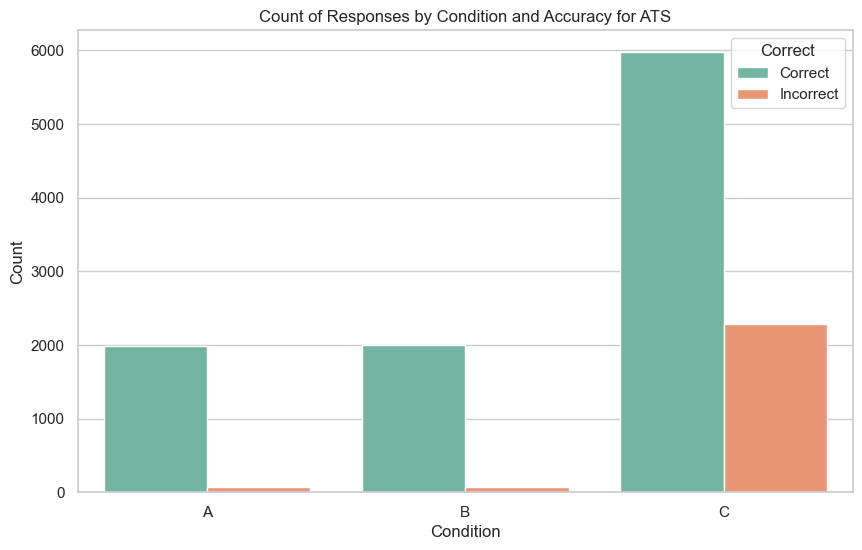

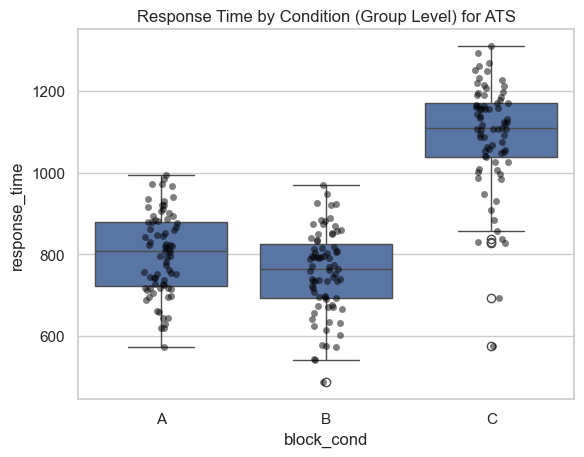

In [29]:
# plot group level count plot for accuracy (correct by condition) for ATS
plt.figure(figsize=(10, 6))
# print values of correct and incorrect by condition for ATS
for condition in ats_df['block_cond'].unique():
    print(f"Number of Correct Responses for {condition} condition: {ats_df[ats_df['block_cond'] == condition]['correct'].value_counts().get(1, 0)}")
    print(f"Number of Incorrect Responses for {condition} condition: {ats_df[ats_df['block_cond'] == condition]['correct'].value_counts().get(0, 0)}")
# set 0 for incorrect and 1 for correct
ats_df['correct'] = ats_df['correct'].map({0: 'Incorrect', 1: 'Correct'})
sns.countplot(data=ats_df, x='block_cond', hue='correct', palette='Set2')
plt.title('Count of Responses by Condition and Accuracy for ATS')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.legend(title='Correct', loc='upper right')
plt.show()
# group response time by condition for ATS
grouped_rt = ats_df.groupby(['block_cond', 'subjectID'])['response_time'].mean().reset_index()
sns.boxplot(data=grouped_rt, x='block_cond', y='response_time')
sns.stripplot(data=grouped_rt, x='block_cond', y='response_time', color='black', alpha=0.5, jitter=True)
plt.title("Response Time by Condition (Group Level) for ATS")
plt.show()


In [30]:
nts_df = load_task_data("NTS", columns_to_extract)
nts_df = add_study_and_site_columns(nts_df)
nts_df = nts_df[nts_df['block']=='test']
nts_df.head()


,subjectID,block,block_cond,correct,response_time,study,site
24,7049,test,A,1,658,obs,UI
25,7049,test,A,1,471,obs,UI
26,7049,test,A,1,492,obs,UI
27,7049,test,A,1,532,obs,UI
28,7049,test,A,1,494,obs,UI


Number of Correct Responses for A condition: 1982
Number of Incorrect Responses for A condition: 58
Number of Correct Responses for B condition: 1938
Number of Incorrect Responses for B condition: 102
Number of Correct Responses for C condition: 6185
Number of Incorrect Responses for C condition: 1975


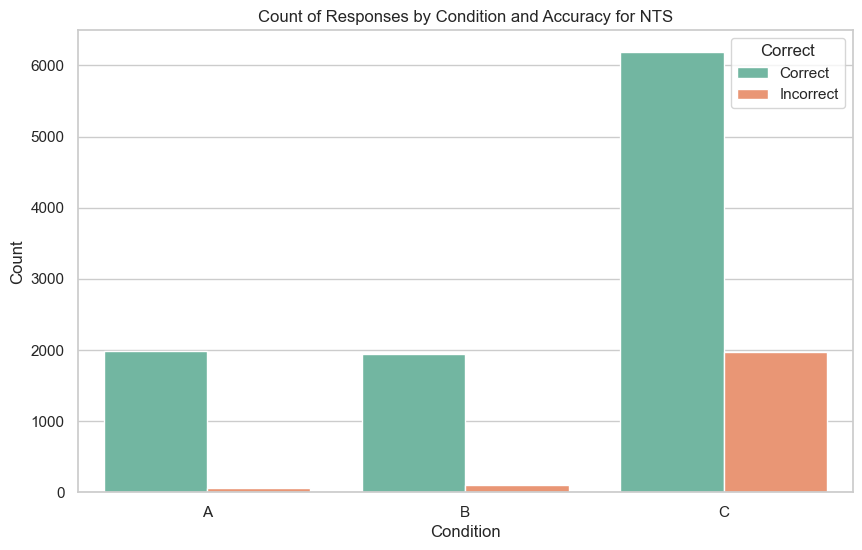

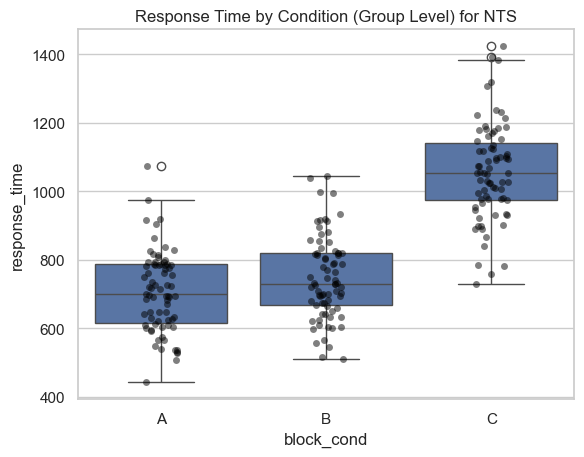

In [31]:
# plot group level count plot for accuracy (correct by condition) for NTS
plt.figure(figsize=(10, 6))
# print values of correct and incorrect by condition for NTS
for condition in nts_df['block_cond'].unique():
    print(f"Number of Correct Responses for {condition} condition: {nts_df[nts_df['block_cond'] == condition]['correct'].value_counts().get(1, 0)}")
    print(f"Number of Incorrect Responses for {condition} condition: {nts_df[nts_df['block_cond'] == condition]['correct'].value_counts().get(0, 0)}")
# set 0 for incorrect and 1 for correct
nts_df['correct'] = nts_df['correct'].map({0: 'Incorrect', 1: 'Correct'})
sns.countplot(data=nts_df, x='block_cond', hue='correct', palette='Set2')
plt.title('Count of Responses by Condition and Accuracy for NTS')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.legend(title='Correct', loc='upper right')
plt.show()
# group response time by condition for NTS
grouped_rt = nts_df.groupby(['block_cond', 'subjectID'])['response_time'].mean().reset_index()
sns.boxplot(data=grouped_rt, x='block_cond', y='response_time')
sns.stripplot(data=grouped_rt, x='block_cond', y='response_time', color='black', alpha=0.5, jitter=True)
plt.title("Response Time by Condition (Group Level) for NTS")
plt.show()

Number of Correct Responses for 1-Back condition: 6968
Number of Incorrect Responses for 1-Back condition: 342
Number of Correct Responses for 2-Back condition: 5713
Number of Incorrect Responses for 2-Back condition: 1167


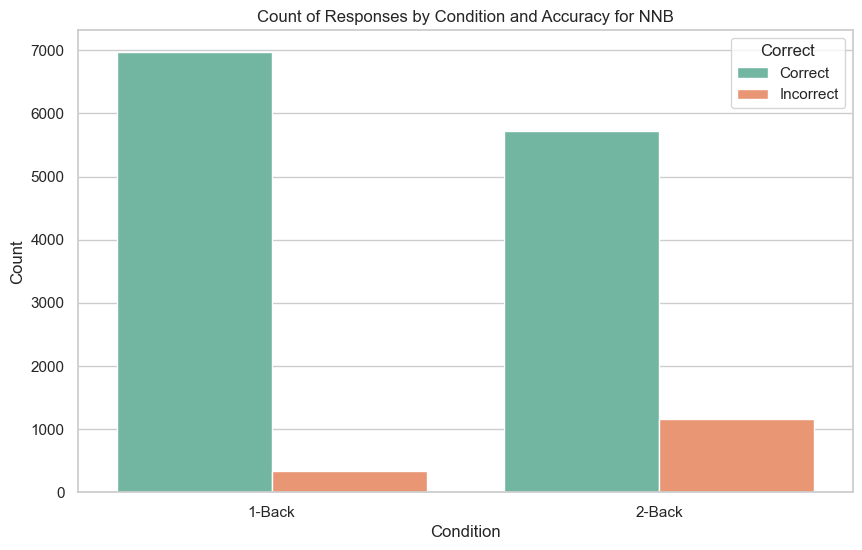

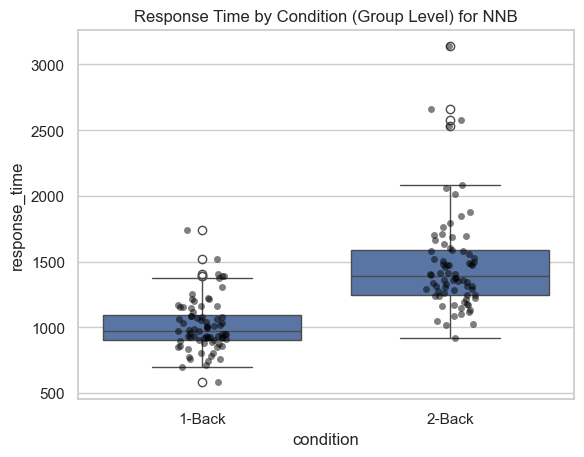

In [32]:
columns_to_extract = ['block', 'condition', 'correct', 'response_time']
nnb_df = load_task_data("NNB", columns_to_extract)
nnb_df = add_study_and_site_columns(nnb_df)
nnb_df = nnb_df[nnb_df['block']=='test']
# plot group level count plot for accuracy (correct by condition) for NNB
plt.figure(figsize=(10, 6))
# print values of correct and incorrect by condition for NNB
for condition in nnb_df['condition'].unique():
    print(f"Number of Correct Responses for {condition} condition: {nnb_df[nnb_df['condition'] == condition]['correct'].value_counts().get(1, 0)}")
    print(f"Number of Incorrect Responses for {condition} condition: {nnb_df[nnb_df['condition'] == condition]['correct'].value_counts().get(0, 0)}")
# set 0 for incorrect and 1 for correct
nnb_df['correct'] = nnb_df['correct'].map({0: 'Incorrect', 1: 'Correct'})
sns.countplot(data=nnb_df, x='condition', hue='correct', palette='Set2')
plt.title('Count of Responses by Condition and Accuracy for NNB')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.legend(title='Correct', loc='upper right')
plt.show()
# group response time by condition for NNB
grouped_rt = nnb_df.groupby(['condition', 'subjectID'])['response_time'].mean().reset_index()
sns.boxplot(data=grouped_rt, x='condition', y='response_time')
sns.stripplot(data=grouped_rt, x='condition', y='response_time', color='black', alpha=0.5, jitter=True)
plt.title("Response Time by Condition (Group Level) for NNB")
plt.show()

Number of Correct Responses for 1-Back condition: 6647
Number of Incorrect Responses for 1-Back condition: 663
Number of Correct Responses for 2-Back condition: 4763
Number of Incorrect Responses for 2-Back condition: 2117


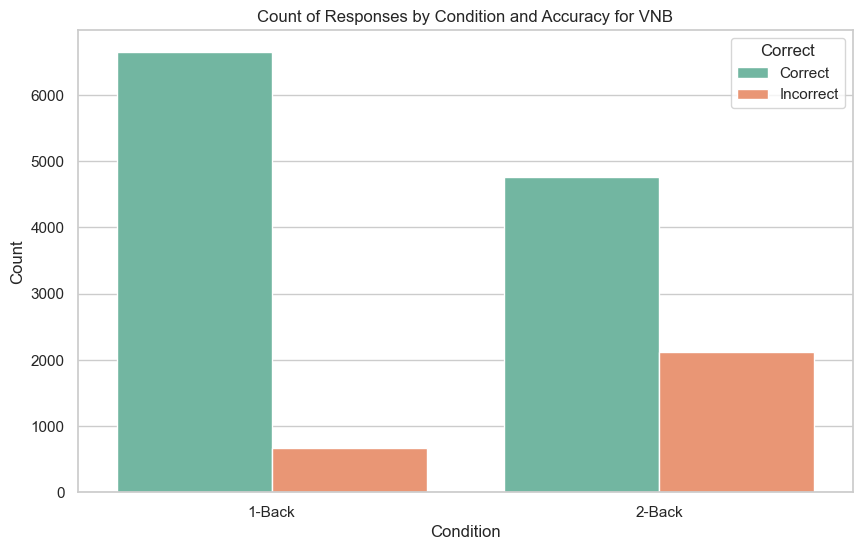

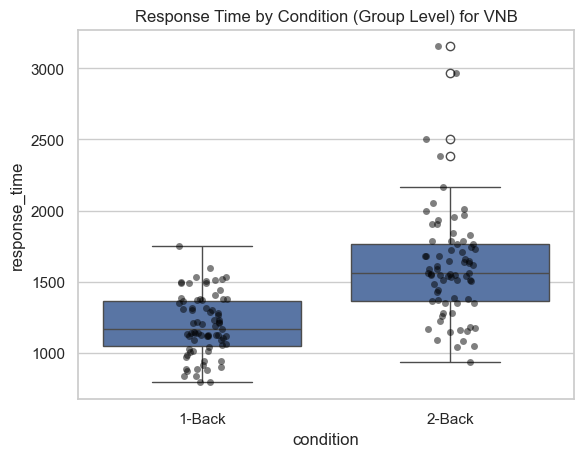

In [33]:
vnb_df = load_task_data("VNB", columns_to_extract)
vnb_df = add_study_and_site_columns(vnb_df)
vnb_df = vnb_df[vnb_df['block']=='test']
# plot group level count plot for accuracy (correct by condition) for VNB
plt.figure(figsize=(10, 6))
# print values of correct and incorrect by condition for VNB
for condition in vnb_df['condition'].unique():
    print(f"Number of Correct Responses for {condition} condition: {vnb_df[vnb_df['condition'] == condition]['correct'].value_counts().get(1, 0)}")
    print(f"Number of Incorrect Responses for {condition} condition: {vnb_df[vnb_df['condition'] == condition]['correct'].value_counts().get(0, 0)}")
# set 0 for incorrect and 1 for correct
vnb_df['correct'] = vnb_df['correct'].map({0: 'Incorrect', 1: 'Correct'})
sns.countplot(data=vnb_df, x='condition', hue='correct', palette='Set2')
plt.title('Count of Responses by Condition and Accuracy for VNB')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.legend(title='Correct', loc='upper right')
plt.show()
# group response time by condition for VNB
grouped_rt = vnb_df.groupby(['condition', 'subjectID'])['response_time'].mean().reset_index()
sns.boxplot(data=grouped_rt, x='condition', y='response_time')
sns.stripplot(data=grouped_rt, x='condition', y='response_time', color='black', alpha=0.5, jitter=True)
plt.title("Response Time by Condition (Group Level) for VNB")
plt.show()

In [34]:

def group_lc_plot(df):
    """
    Generates group-level plots for LC (Learning Condition) data.

    Parameters:
        df (pd.DataFrame): Must contain 'subjectID', 'condition', 'block_c', 'response',
                           'correct', and 'response_time'.

    Returns:
        tuple: Two matplotlib Axes objects: bar plot axis and response time axis.
    """
    test = df[df['condition'] == 'test'].copy()

    # Compute subject-level summaries first
    subject_summary = (
        test.groupby(['subjectID', 'block_c'])
        .agg(
            total_trials=('response', 'count'),
            total_responses=('response', lambda x: (x != 'None').sum()),
            correct_responses=('correct', 'sum'),
            accuracy=('correct', lambda x: 100 * x.sum() / len(x))
        )
        .reset_index()
    )

    # Group-level summary (mean ± SEM)
    group_summary = (
        subject_summary.groupby('block_c')
        .agg(
            total_trials_mean=('total_trials', 'mean'),
            total_trials_sem=('total_trials', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
            total_responses_mean=('total_responses', 'mean'),
            total_responses_sem=('total_responses', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
            correct_responses_mean=('correct_responses', 'mean'),
            correct_responses_sem=('correct_responses', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
            accuracy_mean=('accuracy', 'mean'),
            accuracy_sem=('accuracy', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        )
        .reset_index()
    )

    # Prep for bar plot
    plot_data = pd.DataFrame({
        'Block': group_summary['block_c'].map({1: 'Block 1', 2: 'Block 2'}),
        'Total Responses': group_summary['total_responses_mean'],
        'Correct Responses': group_summary['correct_responses_mean'],
        'Total Responses SEM': group_summary['total_responses_sem'],
        'Correct Responses SEM': group_summary['correct_responses_sem']
    })
    print(plot_data.head())

    # Melt both mean and SEM into long format
    mean_melt = plot_data.melt(id_vars='Block',
                            value_vars=['Total Responses', 'Correct Responses'],
                            var_name='Response Type', value_name='Mean Count')

    sem_data = pd.DataFrame({
        'Block': list(plot_data['Block']) * 2,
        'Response Type': ['Total Responses'] * len(plot_data) + ['Correct Responses'] * len(plot_data),
        'SEM': list(plot_data['Total Responses SEM']) + list(plot_data['Correct Responses SEM'])
    })

    # Merge the two
    # Concatenate side by side along columns (axis=1)
    melted = pd.concat([mean_melt.reset_index(drop=True), sem_data[['SEM']].reset_index(drop=True)], axis=1)
    print(melted.head())

    # Bar Plot
    plt.figure(figsize=(8, 6))
    bar_ax = sns.barplot(x='Block', y='Mean Count', hue='Response Type', data=melted, palette='muted', ci=None)
    for index, row in melted.iterrows():
        bar_ax.errorbar(x=index % 2, y=row['Mean Count'], yerr=row['SEM'], fmt='none', c='black', capsize=5)
    plt.title('Group-Level Total and Correct Responses by Block')
    plt.tight_layout()

    # Response time plot
    plt.figure(figsize=(10, 6))
    test['correct_label'] = test['correct'].map({0: 'Incorrect', 1: 'Correct'})
    resp_time_ax = sns.stripplot(
        x='block_c', y='response_time', data=test, hue='correct_label',
        alpha=0.3, dodge=True, palette={'Correct': 'green', 'Incorrect': 'red'}
    )
    sns.boxplot(
        x='block_c', y='response_time', data=test, whis=np.inf, linewidth=0.5,
        color='gray'
    )
    plt.legend(title='Correctness', loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.title('Group-Level Response Time by Block')
    plt.tight_layout()

    return bar_ax, resp_time_ax

     Block  Total Responses  Correct Responses  Total Responses SEM  \
0  Block 1        18.589041          15.917808             1.080975   
1  Block 2        17.808219          14.397260             0.952378   

   Correct Responses SEM  
0               0.983260  
1               0.774336  
     Block      Response Type  Mean Count       SEM
0  Block 1    Total Responses   18.589041  1.080975
1  Block 2    Total Responses   17.808219  0.952378
2  Block 1  Correct Responses   15.917808  0.983260
3  Block 2  Correct Responses   14.397260  0.774336
Percent Correct for Block 1: 85.63%
Percent Correct for Block 2: 80.85%


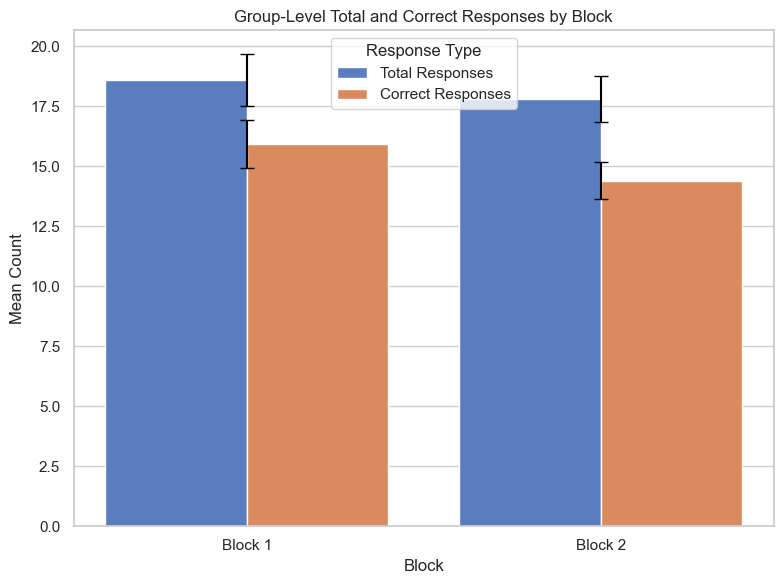

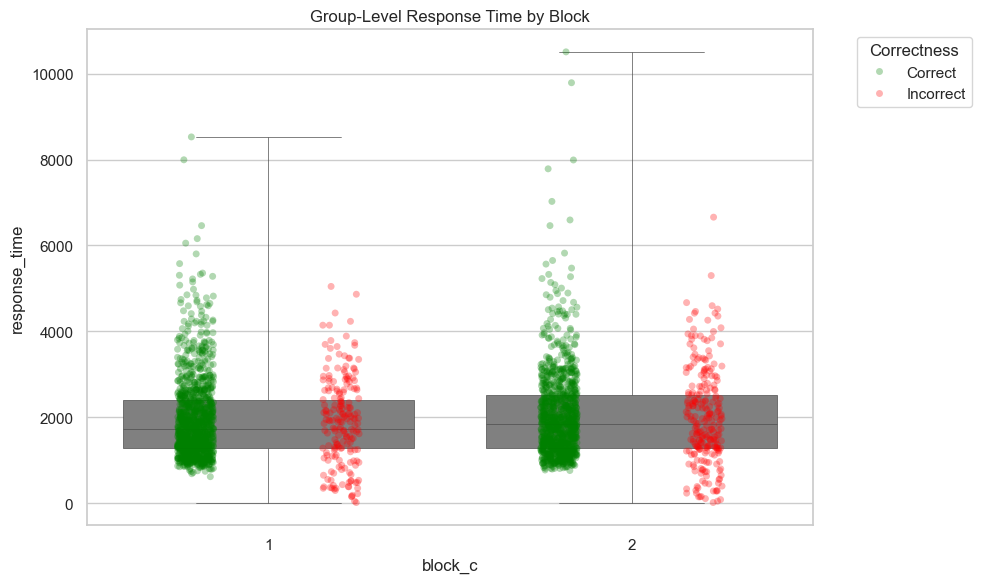

In [35]:
columns_to_extract = ['block_c', 'condition', 'response', 'correct', 'response_time']
lc_df = load_task_data("LC", columns_to_extract)
lc_df = add_study_and_site_columns(lc_df)
lc_df = lc_df[lc_df['condition']=='test']
bar_ax, resp_time_ax = group_lc_plot(lc_df)
# print percent correct by block
for block in lc_df['block_c'].unique():
    percent_correct = 100 * lc_df[lc_df['block_c'] == block]['correct'].mean()
    print(f"Percent Correct for Block {block}: {percent_correct:.2f}%")
    
plt.show()


In [36]:
def group_pc_plot_with_swarm(df):
    """
    Generates a group-level plot for PC (Performance Condition) data, showing:
    - Bar plot of mean proportion correct per condition
    - Swarm plot of individual subject-level accuracy
    
    Parameters:
        df (pd.DataFrame): Must include 'subjectID', 'condition', and 'correct'.

    Returns:
        Axes: Combined plot with bars, error bars, and individual points.
    """
    test = df[df['condition'] == 'test'].copy()
    test['correct'] = test['correct'].astype(int)

    # Subject-level accuracy
    subject_summary = (
        test.groupby(['subjectID', 'condition'])
        .agg(accuracy=('correct', 'mean'))
        .reset_index()
    )

    # Group-level summary
    group_summary = (
        subject_summary.groupby('condition')
        .agg(
            accuracy_mean=('accuracy', 'mean'),
            accuracy_sem=('accuracy', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
        )
        .reset_index()
    )

    plt.figure(figsize=(8, 6))

    # Bar plot (group-level means)
    ax = sns.barplot(data=group_summary, x='condition', y='accuracy_mean', 
                     palette='muted', ci=None, zorder=1)

    # Error bars
    ax.errorbar(
        x=np.arange(len(group_summary)),
        y=group_summary['accuracy_mean'],
        yerr=group_summary['accuracy_sem'],
        fmt='none', c='black', capsize=5, zorder=2
    )

    # Swarm plot (individual-level points)
    sns.swarmplot(data=subject_summary, x='condition', y='accuracy', 
                  color='black', size=4, alpha=0.7, zorder=3)

    # Optional annotations
    for idx, row in group_summary.iterrows():
        ax.annotate(f"{row['accuracy_mean']*100:.1f}%", (idx, row['accuracy_mean'] + 0.02),
                    ha='center', fontsize=9)

    plt.title("Group-Level Accuracy by Condition")
    plt.ylabel("Proportion Correct")
    plt.xlabel("Condition")
    plt.ylim(0, 1.05)
    plt.tight_layout()

    return ax

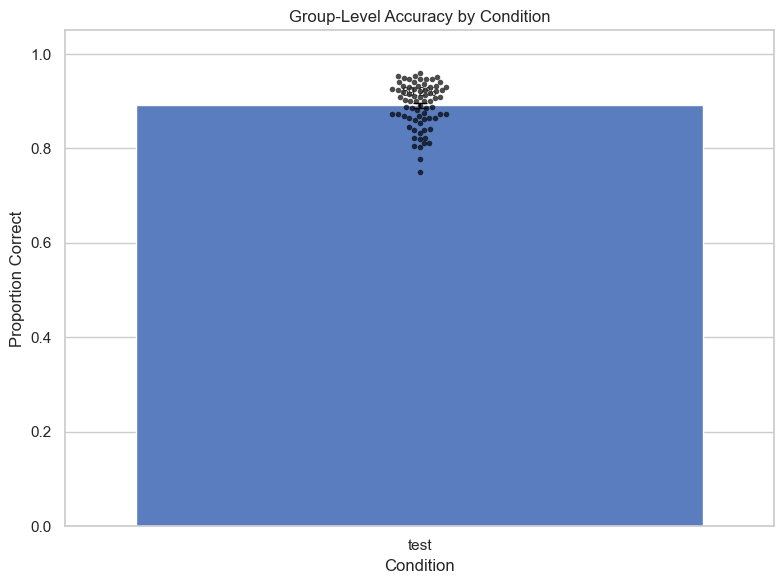

In [37]:
columns_to_extract = ['condition', 'correct']
pc_df = load_task_data("PC", columns_to_extract)
pc_df = add_study_and_site_columns(pc_df)
pc_df = pc_df[pc_df['condition']=='test']
ax = group_pc_plot_with_swarm(pc_df)
plt.show()


In [38]:
def group_dsst_plot(df):
    """
    Generates group-level DSST plots with:
    - Box + swarm plot of mean response time by correctness
    - Bar + swarm plot of proportion correct per subject

    Parameters:
        df (pd.DataFrame): Must contain 'subjectID', 'condition', 'correct', 'acc_sum', 'countdown'.

    Returns:
        tuple: (response_time_ax, proportion_correct_ax)
    """
    test = df[df['condition'] == 'test'].copy()

    # Compute response time per trial
    test['response_time'] = test['countdown'].diff(-1).abs()

    # Map correct label
    test['correct_label'] = test['correct'].map({0: 'Incorrect', 1: 'Correct'})

    # ---- Subject-level summaries ----
    rt_summary = (
        test.groupby(['subjectID', 'correct_label'])
        .agg(mean_rt=('response_time', 'mean'))
        .reset_index()
    )

    accuracy_summary = (
        test.groupby('subjectID')
        .agg(
            total_trials=('correct', 'count'),
            correct_trials=('correct', 'sum')
        )
        .assign(proportion_correct=lambda d: d['correct_trials'] / d['total_trials'])
        .reset_index()
    )

    # ---- Response Time Plot ----
    plt.figure(figsize=(10, 6))
    g = sns.FacetGrid(rt_summary, col='correct_label', sharey=False, height=5, aspect=1)
    g.map_dataframe(sns.boxplot, x=None, y='mean_rt', color='lightgray')
    g.map_dataframe(sns.stripplot, x=None, y='mean_rt', color='black', alpha=0.6)
    # Fix x-axis labels to match facet titles
    for ax, label in zip(g.axes.flat, g.col_names):
        ax.set_xticks([0])
    g.set_titles("{col_name}")
    g.set_axis_labels("", "Mean Response Time (ms)")
    plt.tight_layout()

    # ---- Proportion Correct Plot ----
    group_mean = accuracy_summary['proportion_correct'].mean()
    group_sem = accuracy_summary['proportion_correct'].sem()

    plt.figure(figsize=(8, 6))
    pc_ax = sns.barplot(x=['Group'], y=[group_mean], yerr=[group_sem], palette='muted', ci=None)
    sns.stripplot(x=['Group']*len(accuracy_summary), y=accuracy_summary['proportion_correct'], 
                  color='black', alpha=0.6, jitter=True)
    plt.title('Proportion Correct Across Subjects')
    plt.ylabel('Proportion Correct')
    plt.tight_layout()

    return g, pc_ax

<Figure size 1000x600 with 0 Axes>

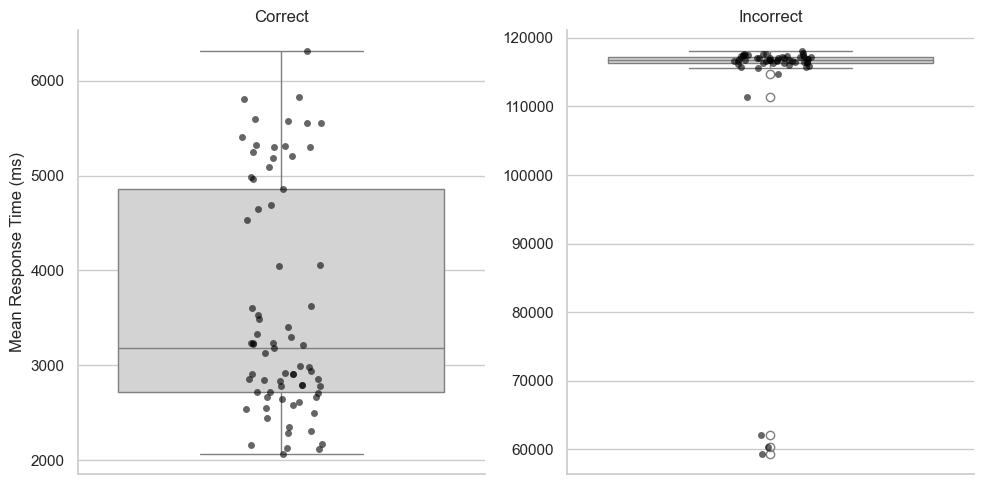

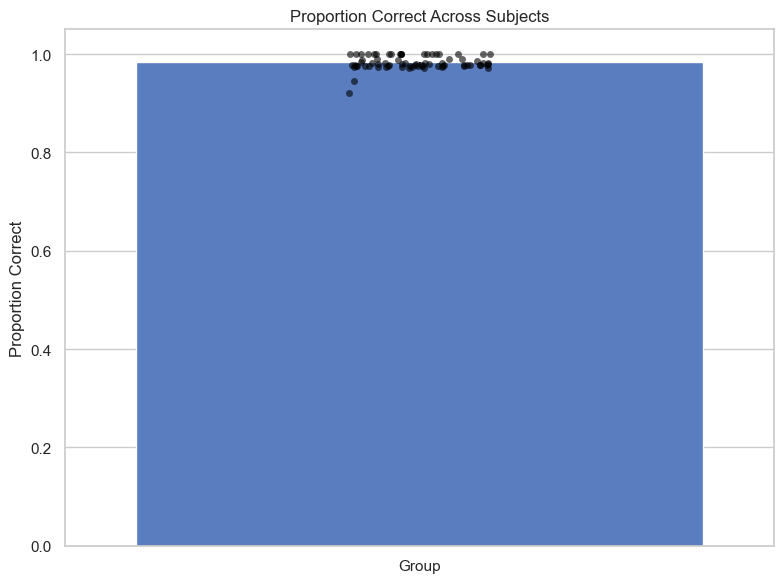

In [39]:
columns_to_extract = ['condition', 'correct', 'acc_sum', 'countdown']
dsst_df = load_task_data("DSST", columns_to_extract)
dsst_df = add_study_and_site_columns(dsst_df)
rt_ax, pc_ax = group_dsst_plot(dsst_df)
plt.show()

In [42]:

def group_sm_plot(df):
    """
    Generates a group-level plot for response times by target congruence.
    
    Parameters:
        df (pd.DataFrame): Input data containing 'subjectID', 'block', 'target_congruent', and 'response_time'.
    
    Returns:
        matplotlib.axes.Axes: The response time plot.
    """
    # Filter test block
    test = df[df['block'] == 'test'].copy()
    
    # Map congruence labels
    mapping = {'no': 'Incongruent', 'yes': 'Congruent'}
    test['target_congruent'] = test['target_congruent'].map(mapping)

    # Subject-level mean RTs by congruence
    rt_summary = (
        test.groupby(['subjectID', 'target_congruent'])
        .agg(mean_rt=('response_time', 'mean'))
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(10, 6))
    sm_ax = sns.boxplot(data=rt_summary, x='target_congruent', y='mean_rt', color='lightgray')
    sns.stripplot(data=rt_summary, x='target_congruent', y='mean_rt', color='black', alpha=0.6, jitter=True)

    plt.title("Mean Response Time by Target Congruence (Group Level)")
    plt.xlabel("Target Congruence")
    plt.ylabel("Mean Response Time (ms)")
    plt.tight_layout()
    plt.bar(data=test, x='correct', y='response_time', color='lightgray', alpha=0.5, height=0.5)
    plt.show()
    return sm_ax

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

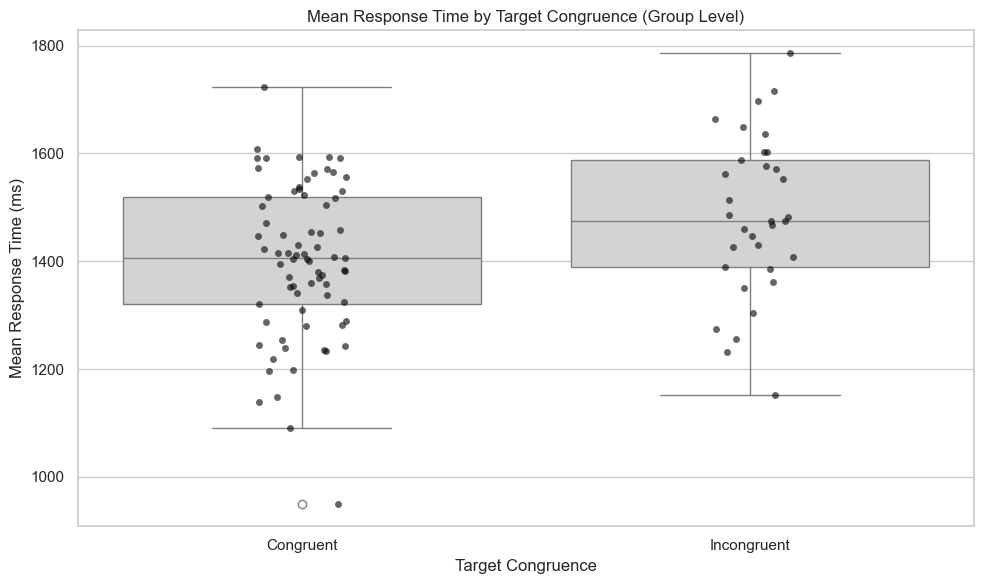

In [43]:
columns_to_extract = ['block', 'target_congruent', 'response_time', 'correct']
sm_df = load_task_data("SM", columns_to_extract)
sm_df = add_study_and_site_columns(sm_df)
sm_ax = group_sm_plot(sm_df)
plt.show()

In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz, process

def select_key(version):
    """
    Selects the predefined key list based on the version.
    """
    listA = [
        ['book', 'flower', 'train', 'rug', 'meadow', 'harp', 'salt', 'finger', 'apple', 'log', 'button', 'key', 'gold', 'rattle'],
        ['bowl', 'dawn', 'judge', 'grant', 'insect', 'plane', 'county', 'pool', 'seed', 'sheep', 'meal', 'coat', 'bottle', 'peach', 'chair']
    ]
    listB = [
        ['street', 'grass', 'door', 'arm', 'star', 'wife', 'window', 'city', 'pupil', 'cabin', 'lake', 'pipe', 'skin', 'fire', 'clock'],
        ['baby', 'ocean', 'palace', 'lip', 'bar', 'dress', 'steam', 'coin', 'rock', 'army', 'building', 'friend', 'storm', 'village', 'cell']
    ]
    listC = [
        ['tower', 'wheat', 'queen', 'sugar', 'home', 'boy', 'doctor', 'camp', 'flag', 'letter', 'corn', 'nail', 'cattle', 'shore', 'body'],
        ['sky', 'dollar', 'valley', 'butter', 'hall', 'diamond', 'winter', 'mother', 'christmas', 'meat', 'forest', 'tool', 'plant', 'money', 'hotel']
    ]
    keys = {'A': [listA[0], listA[1]], 'B': [listB[0], listB[1]], 'C': [listC[0], listC[1]]}
    if version not in keys:
        raise ValueError("Invalid version. Please choose 'A', 'B', or 'C'.")
    return keys[version]

def filter_data(df):
    """
    Removes the first row from the DataFrame and resets the index.
    """
    filtered = df.iloc[1:]
    return filtered.reset_index(drop=True)

def find_word_ranges(data):
    """
    Identify row index ranges delimited by 'enter' in the 'response' column.
    """
    indices = data[data['response'] == 'enter'].index
    ranges = [[start, end] for start, end in zip(indices[:-1], indices[1:])]
    return ranges

def add_metadata(data, ranges):
    updated_ranges = []
    for r in ranges:
        start, end = r[0], r[1]

        raw_response = data.iloc[end].get('multichar_response', '')
        response_text = str(raw_response)[:-5] if isinstance(raw_response, str) and len(raw_response) >= 5 else ''
        backspace_flag = 1 if any('backspace' in str(data.iloc[j]['response']) for j in range(start, end)) else 0
        time_diff = data.iloc[end]['block_dur'] - data.iloc[start]['block_dur']
        updated_ranges.append([response_text, start, end, backspace_flag, time_diff])
    return updated_ranges

def fuzzy_match_by_block(word_ranges, word_list, block_c_list):
    """
    Performs fuzzy matching while tracking repeats **within** each `block_c` group.
    Returns a list of [word, best_match, ratio, backspace, repeat, correct, block_c].
    """
    from collections import defaultdict

    results = []
    used_by_block = defaultdict(set)

    for sub, block_c in zip(word_ranges, block_c_list):
        print(f"Starting fuzzy matching for {sub[0]} in block_c {block_c}...")
        first_item = str(sub[0]) if isinstance(sub, list) and len(sub) > 0 else None
        if first_item:
            best_match = process.extractOne(first_item, word_list, scorer=fuzz.ratio)
            if best_match:
                matched_word, ratio = best_match
                repeat_flag = '1' if matched_word in used_by_block[block_c] else '0'
                correct_flag = '1' if ratio > 80 else '0'
                if correct_flag == '1':
                    used_by_block[block_c].add(matched_word)
                results.append([first_item, matched_word, ratio, sub[3], repeat_flag, correct_flag, block_c])
    print("Fuzzy matching completed.")
    return results

def create_dataframe(data, key, condition):
    """
    Creates a DataFrame of fuzzy matching results for a given condition.
    For 'immediate' or 'learn', the first key list is used; for 'distraction', the second key list.
    """
    word_ranges = find_word_ranges(data)
    word_ranges = add_metadata(data, word_ranges)

    # remove empty ranges
    word_ranges = [w for w in word_ranges if isinstance(w[0], str) and w[0].strip() != '']

    # Match word ranges with block_c values at their end indices
    block_c_list = [data.iloc[w[2]]['block_c'] for w in word_ranges]

    word_list = key[0] if condition in ['immediate', 'learn'] else key[1]
    fuzzy_results = fuzzy_match_by_block(word_ranges, word_list, block_c_list)

    return pd.DataFrame(fuzzy_results, columns=['word', 'best_match', 'ratio', 'backspace', 'repeat', 'correct', 'block_c'])

def wl_group_metrics(df, version):
    """
    Processes a group-level DataFrame to extract fuzzy matching results and metadata.
    
    Parameters:
      df (pd.DataFrame): Input DataFrame expected to contain columns such as 'block_c', 'response',
                         'multichar_response', 'block_dur', and 'condition'.
      version (str): Version key ('A', 'B', or 'C') that selects the predetermined key list.
    
    Returns:
      tuple: (df_all, category) where df_all is a consolidated DataFrame with the following columns:
             'word', 'best_match', 'ratio', 'backspace', 'repeat', 'correct', 'block', 'trial_index',
             and category is an integer flag (1 by default, or 3 if any condition is missing).
    
    The function splits the data by condition ('distr' for distraction, 'immed' for immediate recall,
    and 'learn' for learning trials), processes each subset using fuzzy matching, then concatenates
    the results. Rows are assigned a trial index sequentially.
    """
    category = 1
    key = select_key(version)
    filtered_data = filter_data(df).reset_index(drop=True)
    
    # Split data based on condition
    dist = filtered_data[filtered_data['condition'] == 'distr'].reset_index(drop=True)
    immed = filtered_data[filtered_data['condition'] == 'immed'].reset_index(drop=True)
    learn = filtered_data[filtered_data['condition'] == 'learn'].reset_index(drop=True)
    
    # If any of the conditions are empty, set a different category flag
    if dist.empty or immed.empty or learn.empty:
        category = 3
    
    df_dist = create_dataframe(dist, key, 'distraction')
    df_immed = create_dataframe(immed, key, 'immediate')
    df_learn = create_dataframe(learn, key, 'learn')
    
    df_dist['block'] = 'distraction'
    df_immed['block'] = 'immediate'
    df_learn['block'] = 'learn'
    
    # Concatenate the three conditions into one DataFrame
    df_all = pd.concat([df_dist, df_immed, df_learn], ignore_index=True)
    df_all['trial_index'] = df_all.index
    return df_all, category

In [ ]:
columns_to_extract = ['block_c', 'response', 'multichar_response', 'block_dur', 'condition', 'task_vers']
wl_df = load_task_data("WL", columns_to_extract)
wl_df = add_study_and_site_columns(wl_df)
group_results = []
categories = []

# Group by subject
for subject_id, subject_df in wl_df.groupby('subjectID'):
    version = subject_df['task_vers'].iloc[1]  # assumes each subject has one version

    try:
        subject_results, category = wl_group_metrics(subject_df, version)
        subject_results['subjectID'] = subject_id
        group_results.append(subject_results)
        categories.append((subject_id, category))
    except Exception as e:
        print(f"Error processing subject {subject_id} with version {version}: {e}")

final_group_df = pd.concat(group_results, ignore_index=True)
final_group_df.head()
df_all = final_group_df




Starting fuzzy matching for dollar in block_c 6...
Starting fuzzy matching for valley in block_c 6...
Starting fuzzy matching for hall in block_c 6...
Starting fuzzy matching for money in block_c 6...
Starting fuzzy matching for mother in block_c 6...
Fuzzy matching completed.
Starting fuzzy matching for sugar in block_c 7...
Starting fuzzy matching for queen in block_c 7...
Starting fuzzy matching for boy in block_c 7...
Starting fuzzy matching for doctor in block_c 7...
Starting fuzzy matching for flag in block_c 7...
Starting fuzzy matching for camp in block_c 7...
Starting fuzzy matching for nail in block_c 7...
Starting fuzzy matching for body in block_c 7...
Starting fuzzy matching for cattle in block_c 7...
Starting fuzzy matching for shore in block_c 7...
Fuzzy matching completed.
Starting fuzzy matching for wheat in block_c 1...
Starting fuzzy matching for queen in block_c 1...
Starting fuzzy matching for sugar in block_c 1...
Starting fuzzy matching for home in block_c 1...
S

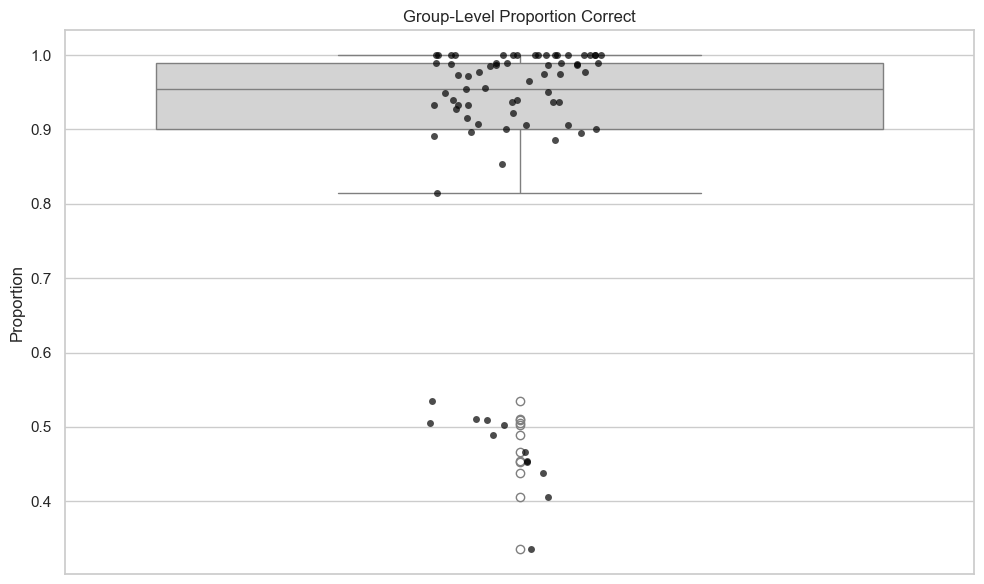

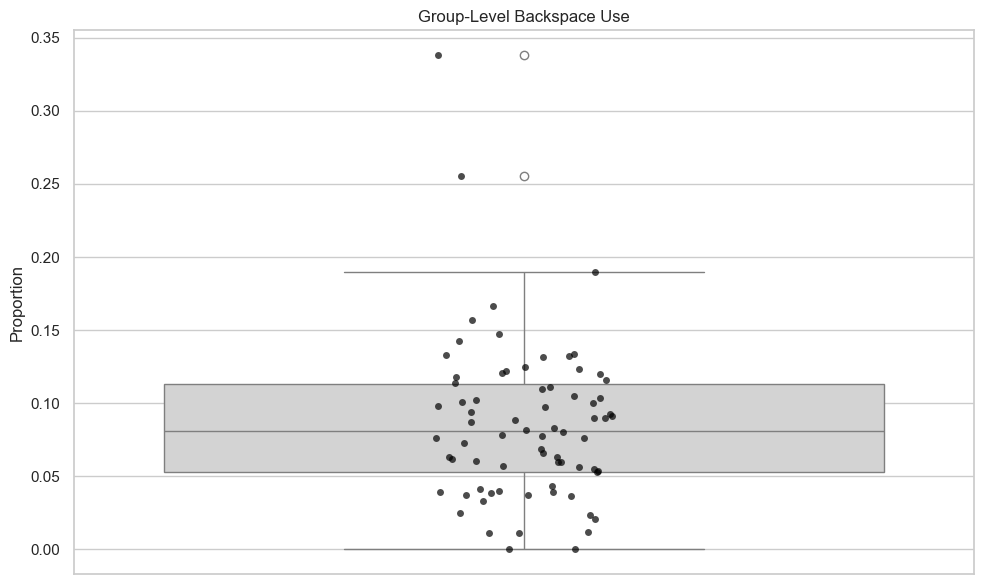

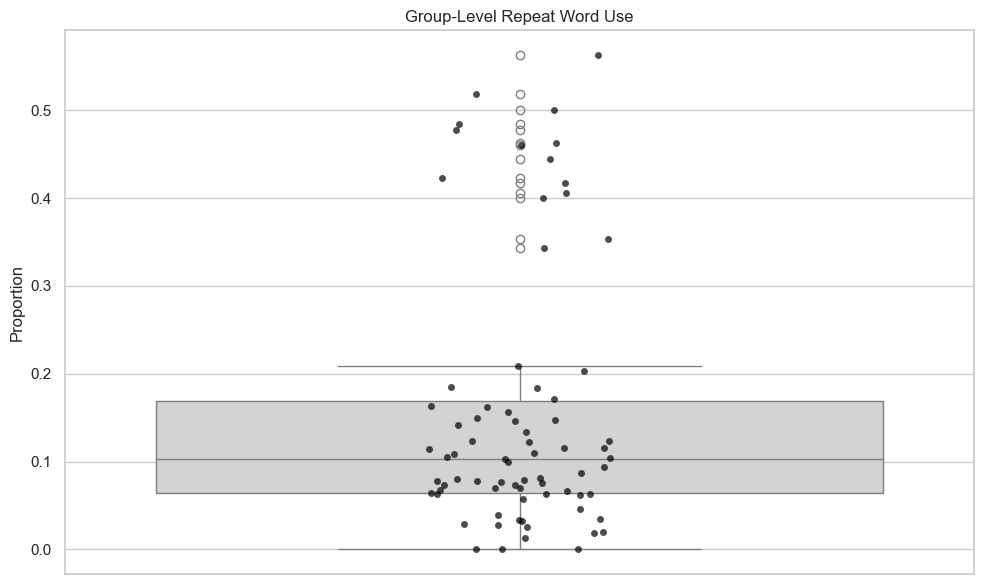

In [ ]:
group_summary = (
    df_all.groupby('subjectID')
    .agg(
        proportion_correct=('correct', lambda x: x.astype(int).mean()),
        proportion_backspace=('backspace', lambda x: x.astype(int).mean()),
        proportion_repeats=('repeat', lambda x: x.astype(int).mean())
    )
    .reset_index()
)
plt.figure(figsize=(10, 6))
sns.boxplot(data=group_summary, y='proportion_correct', color='lightgray')
sns.stripplot(data=group_summary, y='proportion_correct', color='black', alpha=0.7, jitter=True)
plt.title('Group-Level Proportion Correct')
plt.ylabel('Proportion')
plt.tight_layout()
plt.figure(figsize=(10, 6))
sns.boxplot(data=group_summary, y='proportion_backspace', color='lightgray')
sns.stripplot(data=group_summary, y='proportion_backspace', color='black', alpha=0.7, jitter=True)
plt.title('Group-Level Backspace Use')
plt.ylabel('Proportion')
plt.tight_layout()
plt.figure(figsize=(10, 6))
sns.boxplot(data=group_summary, y='proportion_repeats', color='lightgray')
sns.stripplot(data=group_summary, y='proportion_repeats', color='black', alpha=0.7, jitter=True)
plt.title('Group-Level Repeat Word Use')
plt.ylabel('Proportion')
plt.tight_layout()

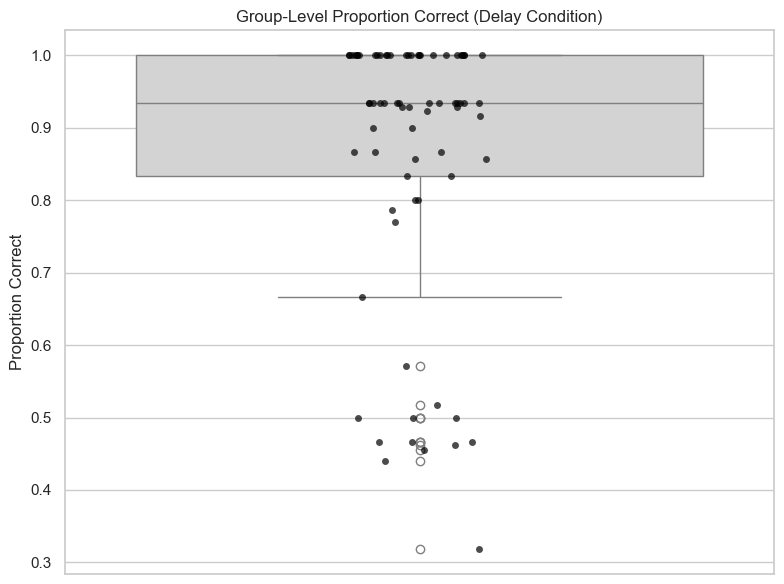

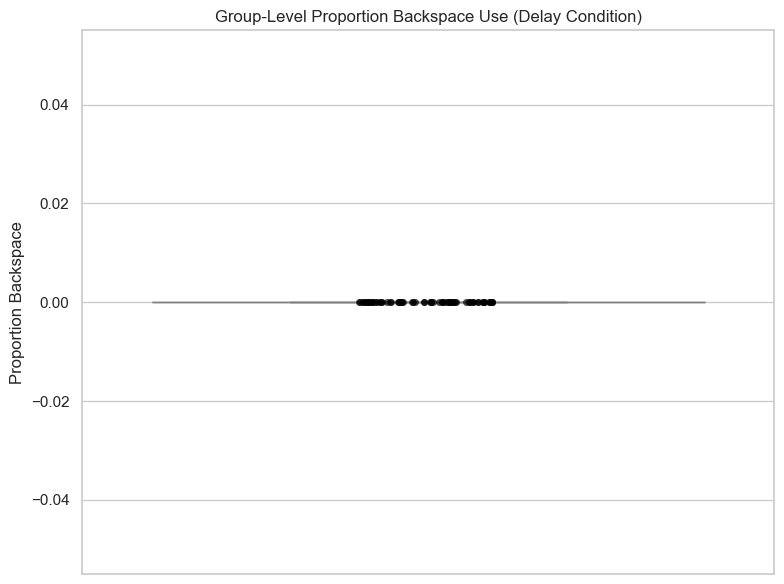

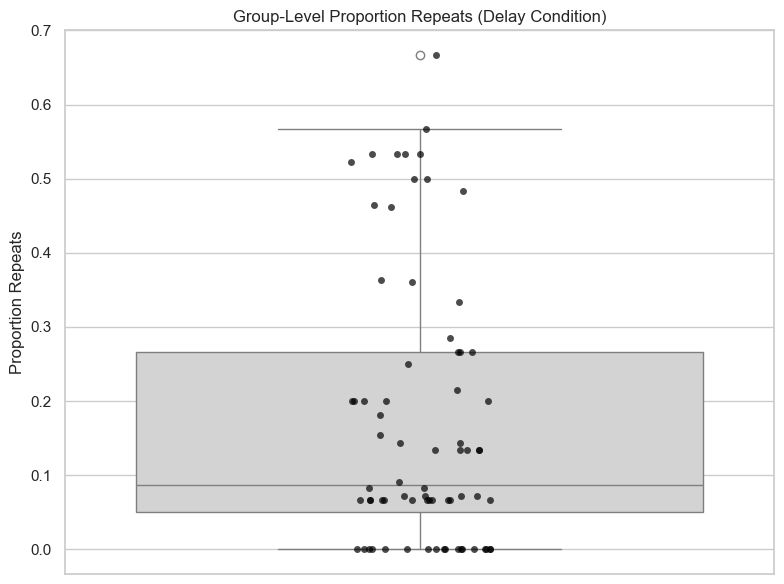

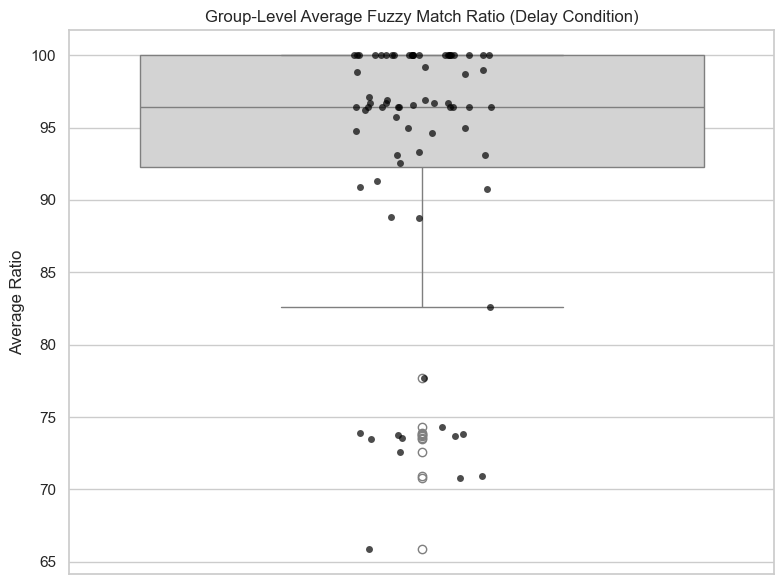

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz, process

# --- DWL_UTILS Functions --- #

def select_key(version):
    """
    Selects the predefined key list based on the version.
    """
    listA = [
        ['book', 'flower', 'train', 'rug', 'meadow', 'harp', 'salt', 'finger', 'apple', 'log', 'button', 'key', 'gold', 'rattle'],
        ['bowl', 'dawn', 'judge', 'grant', 'insect', 'plane', 'county', 'pool', 'seed', 'sheep', 'meal', 'coat', 'bottle', 'peach', 'chair']
    ]
    listB = [
        ['street', 'grass', 'door', 'arm', 'star', 'wife', 'window', 'city', 'pupil', 'cabin', 'lake', 'pipe', 'skin', 'fire', 'clock'],
        ['baby', 'ocean', 'palace', 'lip', 'bar', 'dress', 'steam', 'coin', 'rock', 'army', 'building', 'friend', 'storm', 'village', 'cell']
    ]
    listC = [
        ['tower', 'wheat', 'queen', 'sugar', 'home', 'boy', 'doctor', 'camp', 'flag', 'letter', 'corn', 'nail', 'cattle', 'shore', 'body'],
        ['sky', 'dollar', 'valley', 'butter', 'hall', 'diamond', 'winter', 'mother', 'christmas', 'meat', 'forest', 'tool', 'plant', 'money', 'hotel']
    ]
    keys = {'A': [listA[0], listA[1]], 'B': [listB[0], listB[1]], 'C': [listC[0], listC[1]]}
    if version not in keys:
        raise ValueError("Invalid version. Please choose 'A', 'B', or 'C'.")
    return keys[version]

def filter_data(df):
    """
    Removes the first row from the DataFrame and resets the index.
    """
    filtered = df.iloc[1:]
    return filtered.reset_index(drop=True)
def compute_backspace_flag(df, start, end):
    return 1 if any('backspace' in str(df.iloc[j]['response']) for j in range(start, end)) else 0
def word_analysis_block(df_block, key_list):
    """
    Processes delay condition data.
    Steps:
      1) Trims each row's 'multichar_response' by removing the last 5 characters.
      2) Checks for "backspace" usage.
      3) Uses fuzzy matching on each non-empty processed word against key_list[0]. 
         (If a word is empty after trimming, that trial is skipped.)
      4) Returns a DataFrame with columns:
         [word, best_match, ratio, backspace, repeat, correct, block, trial_index]
    """
    # 1) Process words by trimming the last 5 characters.
    word_list = df_block['multichar_response'].astype(str).apply(
        lambda x: x[:-5] if len(x) >= 5 else x
    ).tolist()

    # 2) Create a list of backspace flags.
    df_block['backspace'] = df_block['response'].astype(str).apply(
        lambda x: 1 if 'backspace' in x.lower().strip() else 0
    )
    backspace_list = df_block['backspace'].tolist()
    # 3) Fuzzy match each non-empty word against key_list[0] while tracking repeats.
    match_list = key_list[0]
    used = []
    fuzzy_results = []
    for i, word in enumerate(word_list):
        # Remove entries that are empty (after stripping whitespace).
        if not word.strip():
            continue  # skip this row entirely
        best_match_data = process.extractOne(word, match_list, scorer=fuzz.ratio)
        if best_match_data:
            matched_word, ratio_score = best_match_data[0], best_match_data[1]
            repeat_flag = '1' if matched_word in used else '0'
            correct_flag = '1' if ratio_score > 80 else '0'
            if correct_flag == '1':
                used.append(matched_word)
            fuzzy_results.append([word, matched_word, ratio_score, backspace_list[i], repeat_flag, correct_flag])
        else:
            fuzzy_results.append([word, '', 0, backspace_list[i], '0', '0'])

    # 4) Build DataFrame. The trial_index is simply the new index of the processed list.
    df_out = pd.DataFrame(fuzzy_results, columns=['word', 'best_match', 'ratio', 'backspace', 'repeat', 'correct'])
    df_out['block'] = 'delay'
    df_out['trial_index'] = range(len(df_out))
    return df_out

# --- Group-Level Processing Functions for DWL_UTILS --- #

def group_dwl_metrics(df):
    """
    Aggregates per-subject metrics from the DWL delay processed DataFrame.
    Expects df to have columns:
      'subject_id', 'trial_index', 'correct', 'backspace', 'repeat', 'ratio'.
    
    Returns a DataFrame with one row per subject.
    """
    summary = df.groupby('subject_id').agg(
        total_trials=('trial_index', 'count'),
        proportion_correct=('correct', lambda x: x.astype(int).mean()),
        proportion_backspace=('backspace', lambda x: x.astype(int).mean()),
        proportion_repeat=('repeat', lambda x: x.astype(int).mean()),
        average_ratio=('ratio', 'mean')
    ).reset_index()
    return summary

# --- Plotting Functions --- #

def plot_dwl_metric_boxplot(summary, metric, title, ylabel):
    """
    Creates a boxplot for a given metric in the group-level summary and overlays subject points.
    """
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(y=metric, data=summary, color='lightgray')
    sns.stripplot(y=metric, data=summary, color='black', alpha=0.7, jitter=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    return ax

def plot_dwl_metrics(summary):
    """
    Creates plots for:
      - Proportion correct
      - Proportion backspace
      - Proportion repeats
      - Average fuzzy matching ratio
    
    Returns a tuple of Axes objects.
    """
    ax1 = plot_dwl_metric_boxplot(summary, 'proportion_correct',
                                  "Group-Level Proportion Correct (Delay Condition)",
                                  "Proportion Correct")
    ax2 = plot_dwl_metric_boxplot(summary, 'proportion_backspace',
                                  "Group-Level Proportion Backspace Use (Delay Condition)",
                                  "Proportion Backspace")
    ax3 = plot_dwl_metric_boxplot(summary, 'proportion_repeat',
                                  "Group-Level Proportion Repeats (Delay Condition)",
                                  "Proportion Repeats")
    ax4 = plot_dwl_metric_boxplot(summary, 'average_ratio',
                                  "Group-Level Average Fuzzy Match Ratio (Delay Condition)",
                                  "Average Ratio")
    return ax1, ax2, ax3, ax4

# --- Full Pipeline Example --- #
df_delay = load_task_data("DWL", columns_to_extract)
df_delay = add_study_and_site_columns(df_delay)
df_delay['subject_id'] = df_delay['subjectID']
subjects = df_delay['subject_id'].unique()
processed_list = []
for subj in subjects:
    subj_df = df_delay[df_delay['subject_id'] == subj].copy()
    # Determine the task version from the second row (if available)
    if len(subj_df) > 1:
        version = subj_df['task_vers'].iloc[1]
    else:
        version = subj_df['task_vers'].iloc[0]
    key_list = select_key(version)
    processed = word_analysis_block(subj_df, key_list)
    processed['subject_id'] = subj
    processed_list.append(processed)

# 5. Combine subject data.
dwl_df_all = pd.concat(processed_list, ignore_index=True)

# 6. Compute group-level metrics.
summary = group_dwl_metrics(dwl_df_all)

# 7. Plot the metrics.
plot_dwl_metrics(summary)
plt.show()


In [ ]:
def get_subject_task_version(df_subject):
    """
    Given a subject-level DataFrame, return the task version from
    the second row (i.e., index 1) of the 'task_vers' column.
    If there is only one row, use that row.
    """
    if len(df_subject) > 1:
        return df_subject['task_vers'].iloc[1]
    else:
        return df_subject['task_vers'].iloc[0]

In [ ]:
columns_to_extract = ['block_c', 'response', 'multichar_response', 'block_dur', 'condition', 'task_vers']
dwl_df = load_task_data("DWL", columns_to_extract)
dwl_df = add_study_and_site_columns(dwl_df)
dwl_df_all = dwl_df
# 'dwl_df_all' is the combined DataFrame with fuzzy matching results for all subjects,
# and it includes a 'subject_id' column.
dwl_df_all.rename(columns={'subjectID': 'subject_id'}, inplace=True)
# First, group the original (or filtered) DataFrame by subject.
subject_versions = (
    dwl_df_all.groupby('subject_id')
      .apply(get_subject_task_version)
      .reset_index()
      .rename(columns={0: 'task_vers'})
)
# Ensure that each subject in dwl_df_all gets the correct task version.
# You can do a merge based on subject_id:
dwl_df_all = dwl_df_all.merge(subject_versions, on='subject_id', how='left')
dwl_df_all.rename(columns={'task_vers_x': 'task_vers'}, inplace=True)
dwl_df_all.drop(columns=['task_vers_y'], inplace=True, errors='ignore')
print(dwl_df_all.columns.tolist())

['subject_id', 'block_c', 'response', 'multichar_response', 'block_dur', 'condition', 'task_vers', 'study', 'site']


In [ ]:

group_summary = group_dwl_metrics(dwl_df_all)
print(group_summary.head())

# Create the plots for the group-level metrics.
ax1, ax2, ax3, ax4 = plot_dwl_metrics(group_summary)
plt.show()

KeyError: "Column(s) ['backspace', 'correct', 'ratio', 'repeat', 'trial_index'] do not exist"

In [ ]:
    # 4. Process each subject individually.
    subjects = dwl_df_all['subject_id'].unique()
    processed_list = []
    for subj in subjects:
        subj_df = dwl_df_all[dwl_df_all['subject_id'] == subj].copy()
        # Get task version from second row.
        if len(subj_df) > 1:
            version = subj_df['task_vers'].iloc[1]
        else:
            version = subj_df['task_vers'].iloc[0]
        key_list = select_key(version)
        # Process using word_analysis_block().
        subj_processed = word_analysis_block(subj_df, key_list)
        subj_processed['subject_id'] = subj  # Tag the subject ID
        processed_list.append(subj_processed)
    
    # 5. Combine all subject outputs.
    dwl_df_all = pd.concat(processed_list, ignore_index=True)
    
    # 6. Compute group-level metrics.
    summary = group_dwl_metrics(dwl_df_all)
    
    # 7. Produce plots.
    ax1, ax2, ax3, ax4 = plot_dwl_metrics(summary)
    plt.show()

UnboundLocalError: local variable 'word_ranges' referenced before assignment